# Data Science Project - Machine Learning Part

In [1]:
import numpy as np
import scipy.stats as sc
import pandas as pd

import seaborn as sns
import matplotlib as mpl

import matplotlib.pyplot as plt
from IPython.display import display

import statsmodels.api as sm

from sklearn.model_selection import train_test_split
from statsmodels.stats import outliers_influence as oi

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import log_loss
from sklearn.feature_selection import RFE
from sklearn import metrics 


import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_colwidth', 250)
sns.set()

In [2]:
def plot_hist2(df,df2,df_col):
    df = df.dropna()  
    df2 = df2.dropna() 
    for d in df_col:
        print("Empirical Distribution of Variable "+d)
        fig, axes = plt.subplots(1,2,figsize=(15,9))
        sns.distplot(df[d],ax=axes[0])
        sns.distplot(df2[d],ax=axes[1])
        axes[0].set_ylabel("Probability")
        axes[1].set_ylabel("Probability")
        plt.suptitle("Empirical Probability Distribution of Numerical Variable "+d)
        plt.show()
        
def get_num_cols(df):
    idx = df.select_dtypes(exclude='object').columns.values
    dF = df[idx].dropna() #remove NaNs or else it cant plot
    return dF.columns

def calculate_metrics(y_test,y_hat):
    c = confusion_matrix(y_test, y_hat)
    print("Confusion matrix is:")
    print(c)
    print("We have",c[0][0]+c[1][1],"correct observations and",c[0][1]+c[1][0], "misclassifications.")
    print(classification_report(y_test, y_hat))
    
def plot_ROC(y_test,X_test,classifier):
    roc = roc_auc_score(y_test, classifier.predict(X_test))
    fpr, tpr, _ = roc_curve(y_test, classifier.predict_proba(X_test)[:,1])
    plt.figure(figsize=(7,7))
    plt.plot(fpr, tpr, label='Classifier area ='+str(np.round(roc,2)))
    plt.plot([0, 1], [0, 1],'--')

    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC curve')
    plt.legend()

    plt.xlim([-0.01, 1.0])
    plt.ylim([0.0, 1.01])
    plt.show()

# Basic info about the dataset

In [3]:
# Data info

dsdata = pd.read_csv("Telco-Customer-Churn.csv")

dsdata = dsdata.drop(dsdata.columns[0], axis=1)
ds = dsdata.copy()

ds['SeniorCitizen'] = ds['SeniorCitizen'].astype(str) #objects are implicitly 'str'
ds['TotalCharges']  = pd.to_numeric(ds.TotalCharges, errors='coerce')

display(ds.head(n=5))
ds.info()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
gender              7043 non-null object
SeniorCitizen       7043 non-null object
Partner             7043 non-null object
Dependents          7043 non-null object
tenure              7043 non-null int64
PhoneService        7043 non-null object
MultipleLines       7043 non-null object
InternetService     7043 non-null object
OnlineSecurity      7043 non-null object
OnlineBackup        7043 non-null object
DeviceProtection    7043 non-null object
TechSupport         7043 non-null object
StreamingTV         7043 non-null object
StreamingMovies     7043 non-null object
Contract            7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7032 non-null float64
Churn               7043 non-null object
dtypes: float64(2), int64(1), object(17)
memory usage: 1.1+ MB


Empirical Distribution of Variable tenure


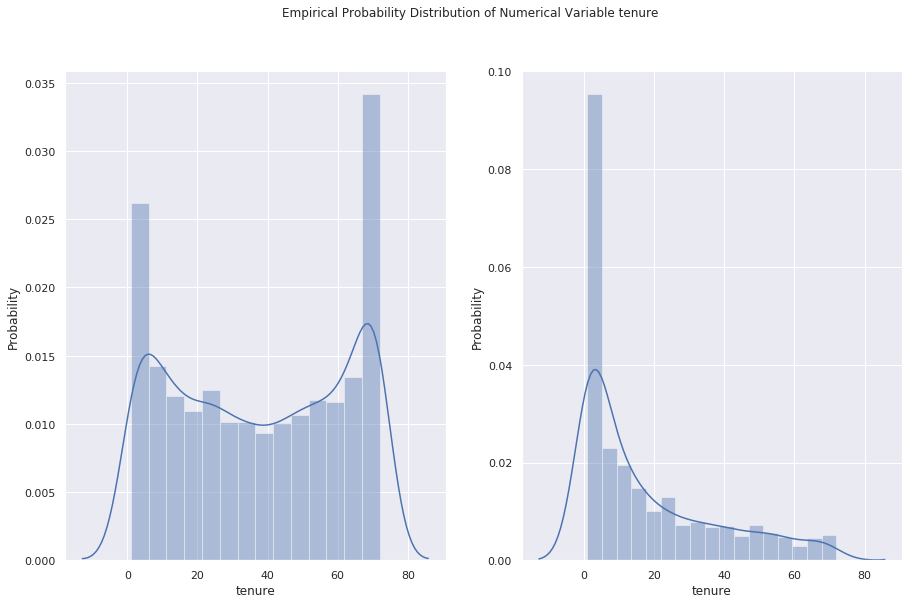

Empirical Distribution of Variable MonthlyCharges


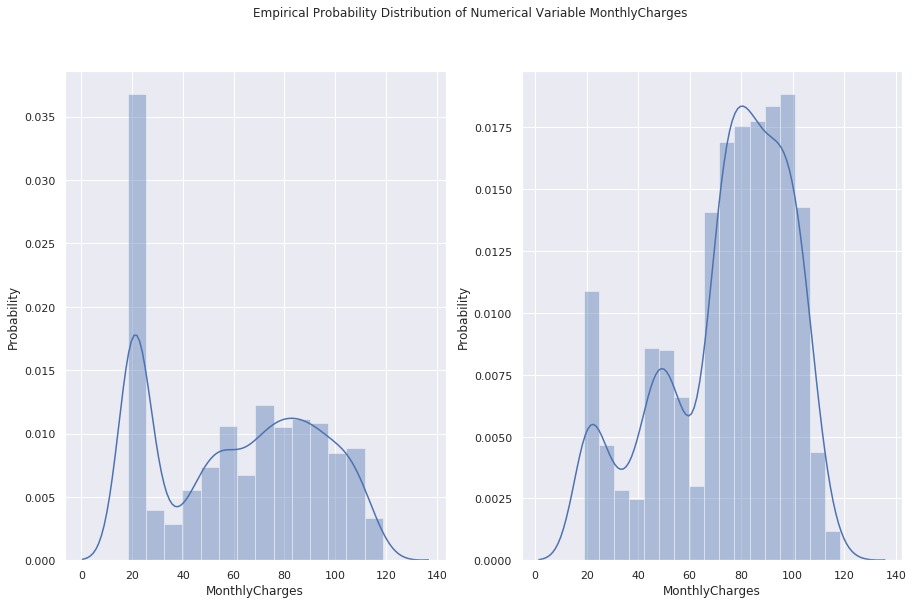

Empirical Distribution of Variable TotalCharges


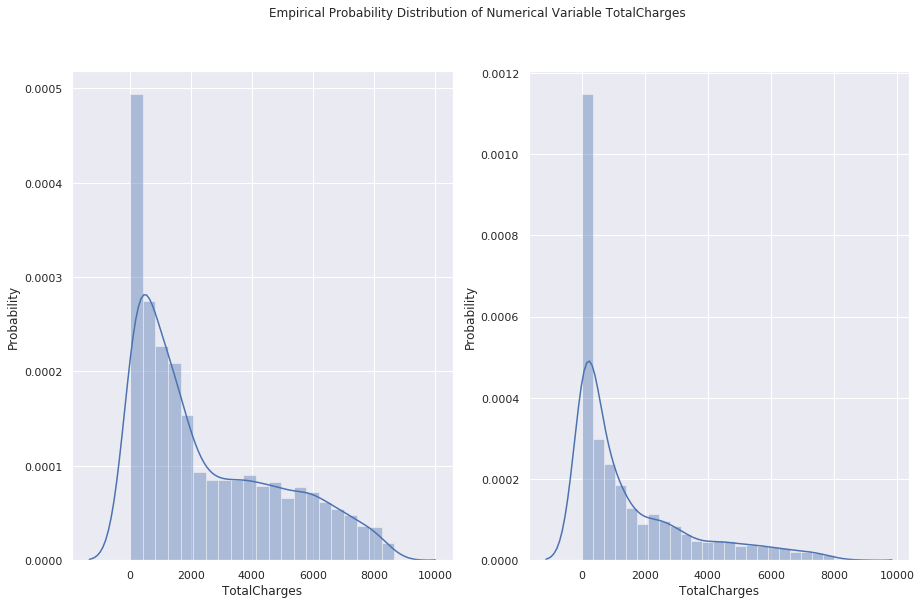

In [4]:
ds_churn = ds.copy()
ds_loyal = ds.copy()
#print(ds_churn['Churn'].value_counts())
#print(ds_loyal['Churn'].value_counts())

ds_churn=ds_churn[(ds_churn[u'Churn']=='Yes')]
ds_loyal=ds_loyal[(ds_loyal[u'Churn']=='No')]

plot_hist2(ds_loyal,ds_churn,get_num_cols(ds))

In [5]:
# Data preparation as all numerical variables

dsn = ds.copy()

dsn['SeniorCitizen'] = dsn['SeniorCitizen'].astype(str)
dsn['TotalCharges']  = pd.to_numeric(dsn.TotalCharges, errors='coerce')

nonnumvar = ['gender','SeniorCitizen','Partner','Dependents','PhoneService','MultipleLines','InternetService','OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies','Contract','PaperlessBilling','PaymentMethod','Churn']

for c,var in enumerate(nonnumvar):
    dsn[var] = dsn[var].astype("category").cat.codes
    
dsn.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
gender              7043 non-null int8
SeniorCitizen       7043 non-null int8
Partner             7043 non-null int8
Dependents          7043 non-null int8
tenure              7043 non-null int64
PhoneService        7043 non-null int8
MultipleLines       7043 non-null int8
InternetService     7043 non-null int8
OnlineSecurity      7043 non-null int8
OnlineBackup        7043 non-null int8
DeviceProtection    7043 non-null int8
TechSupport         7043 non-null int8
StreamingTV         7043 non-null int8
StreamingMovies     7043 non-null int8
Contract            7043 non-null int8
PaperlessBilling    7043 non-null int8
PaymentMethod       7043 non-null int8
MonthlyCharges      7043 non-null float64
TotalCharges        7032 non-null float64
Churn               7043 non-null int8
dtypes: float64(2), int64(1), int8(17)
memory usage: 282.1 KB


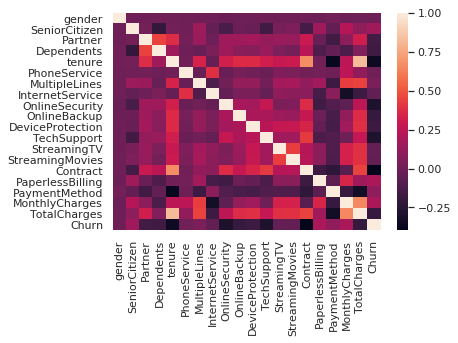

In [6]:
# Check the correlation

corr = dsn.corr()
sns.heatmap(corr, xticklabels=corr.columns,yticklabels=corr.columns)

# Linear Regression 

Distribution of OLS residuals


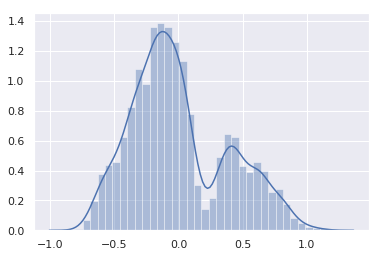

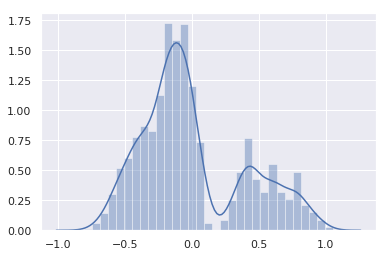

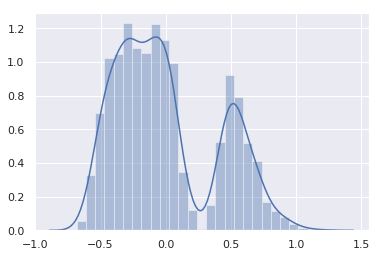

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.275
Model:                            OLS   Adj. R-squared:                  0.273
Method:                 Least Squares   F-statistic:                     140.2
Date:                Sat, 27 Apr 2019   Prob (F-statistic):               0.00
Time:                        21:48:16   Log-Likelihood:                -3100.3
No. Observations:                7032   AIC:                             6241.
Df Residuals:                    7012   BIC:                             6378.
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2157      0.026      8.144      0.000       0.164       0.268
x1            -0.0039      0.009     -0.436      0.663      -0.022       0.014
x2             0.0500      0.013      3.833      0.000       0.024       0.076
x3             0.0016      0.011      0.151      0.880      -0.020       0.023
x4            -0.0238      0.012     -2.065      0.039      -0.046      -0.001
x5            -0.0017      0.001     -3.358      0.001      -0.003      -0.001
x6            -0.1360      0.019     -7.028      0.000      -0.174      -0.098
x7             0.0153      0.006      2.739      0.006       0.004       0.026
x8             0.0515      0.008      6.257      0.000       0.035       0.068
x9            -0.0417      0.006     -7.092      0.000      -0.053      -0.030
x10           -0.0239      0.006     -4.249      0.000      -0.035      -0.013
x11           -0.0170      0.006     -2.922      0.003      -0.028      -0.006
x12           -0.0423      0.006     -7.059      0.000      -0.054      -0.031
x13           -0.0007      0.006     -0.113      0.910      -0.013       0.011
x14        -6.343e-05      0.006     -0.010      0.992      -0.012       0.012
x15           -0.0425      0.009     -4.998      0.000      -0.059      -0.026
x16            0.0502      0.010      5.007      0.000       0.031       0.070
x17            0.0078      0.005      1.705      0.088      -0.001       0.017
x18            0.0058      0.000     17.525      0.000       0.005       0.006
x19        -5.163e-05   6.46e-06     -7.997      0.000   -6.43e-05    -3.9e-05
==============================================================================
Omnibus:                      404.368   Durbin-Watson:                   2.003
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              417.545
Skew:                           0.559   Prob(JB):                     2.14e-91
Kurtosis:                       2.581   Cond. No.                     2.00e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large,  2e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.225
Model:                            OLS   Adj. R-squared:                  0.224
Method:                 Least Squares   F-statistic:                     678.8
Date:                Sat, 27 Apr 2019   Prob (F-statistic):               0.00
Time:                        21:48:16   Log-Likelihood:                -3338.1
No. Observations:                7032   AIC:                             6684.
Df Residuals:                    7028   BIC:                             6712.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0686      0.018      3.823      0.000       0.033       0.104
x1            -0.0028      0.000     -6.070      0.000      -0.004      -0.002
x2             0.0071      0.000     25.572      0.000       0.007       0.008
x3         -7.528e-05   6.32e-06    -11.914      0.000   -8.77e-05   -6.29e-05
==============================================================================
Omnibus:                      536.734   Durbin-Watson:                   2.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              601.728
Skew:                           0.686   Prob(JB):                    2.17e-131
Kurtosis:                       2.589   Cond. No.                     1.25e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.25e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.221
Model:                            OLS   Adj. R-squared:                  0.220
Method:                 Least Squares   F-statistic:                     124.7
Date:                Sat, 27 Apr 2019   Prob (F-statistic):               0.00
Time:                        21:48:16   Log-Likelihood:                -3352.5
No. Observations:                7032   AIC:                             6739.
Df Residuals:                    7015   BIC:                             6856.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3752      0.021     17.468      0.000       0.333       0.417
x1            -0.0089      0.009     -0.956      0.339      -0.027       0.009
x2             0.0645      0.013      4.816      0.000       0.038       0.091
x3            -0.0242      0.011     -2.194      0.028      -0.046      -0.003
x4            -0.0263      0.012     -2.209      0.027      -0.050      -0.003
x5             0.0216      0.017      1.257      0.209      -0.012       0.055
x6             0.0250      0.005      4.753      0.000       0.015       0.035
x7            -0.0115      0.007     -1.608      0.108      -0.025       0.003
x8            -0.0604      0.006    -10.066      0.000      -0.072      -0.049
x9            -0.0403      0.006     -7.165      0.000      -0.051      -0.029
x10           -0.0214      0.006     -3.610      0.000      -0.033      -0.010
x11           -0.0524      0.006     -8.501      0.000      -0.064      -0.040
x12            0.0194      0.006      3.203      0.001       0.008       0.031
x13            0.0190      0.006      3.131      0.002       0.007       0.031
x14           -0.1314      0.007    -18.136      0.000      -0.146      -0.117
x15            0.0779      0.010      7.706      0.000       0.058       0.098
x16            0.0144      0.005      3.122      0.002       0.005       0.023
==============================================================================
Omnibus:                      822.982   Durbin-Watson:                   2.011
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              572.034
Skew:                           0.589   Prob(JB):                    6.09e-125
Kurtosis:                       2.249   Cond. No.                         19.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Variance Inflation Factors:
34.80030871587765 const
1.0018757047597704 gender
1.1496477301673083 SeniorCitizen
1.4611710787710288 Partner
1.3797213890316422 Dependents
7.493653597009099 tenure
1.6226949393484495 PhoneService
1.395897614163496 MultipleLines
1.8243589385879042 InternetService
1.268757645157192 OnlineSecurity
1.2190684755824917 OnlineBackup
1.297942464936379 DeviceProtection
1.3218783000913672 TechSupport
1.4469465459024298 StreamingTV
1.447896394156754 StreamingMovies
2.4933347360016893 Contract
1.2025656447267665 PaperlessBilling
1.1861118107409145 PaymentMethod
4.967860914817181 MonthlyCharges
10.618696508257436 TotalCharges


In [7]:
regvar = ['gender','SeniorCitizen','Partner','Dependents','PhoneService','MultipleLines','InternetService','OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies','Contract','PaperlessBilling','PaymentMethod']


X = dsn.copy().dropna()
Y = pd.DataFrame(X.Churn)
X = X.drop(columns=['Churn'])

X_numeric = pd.DataFrame(dsn.dropna(), columns=['tenure','MonthlyCharges','TotalCharges'])
X_cat = pd.DataFrame(dsn.dropna(), columns= regvar)

X = sm.add_constant(X)
X_numeric = sm.add_constant(X_numeric)
X_cat = sm.add_constant(X_cat)


model = sm.OLS(Y.values,X.values).fit()
model_n = sm.OLS(Y.values,X_numeric.values).fit()
model_c = sm.OLS(Y.values,X_cat.values).fit()

print("Distribution of OLS residuals")
sns.distplot(model.resid)
plt.show()
sns.distplot(model_n.resid)
plt.show()
sns.distplot(model_c.resid)
plt.show()

display(model.summary())
display(model_n.summary())
display(model_c.summary())

#sm.stats.diagnostic.het_breuschpagan(model.resid)

#print(sm.stats.diagnostic.breaks_cusumolsresid(model.resid, ddof=19))
#print(sm.stats.diagnostic.breaks_cusumolsresid(model_n.resid, ddof=3))
#print(sm.stats.diagnostic.breaks_cusumolsresid(model_c.resid, ddof=16))

#check multicollinearity -> assumption violation
def print_VIF(X):
    colnames = list(X.columns)
    for i in range(X.shape[1]):
        print(oi.variance_inflation_factor(X.values, i), colnames[i])
        
print("Variance Inflation Factors:")        
print_VIF(X)

VIF on TotalCharges is high, can ignore constant. Check whether it depends on the other two numeric variables (in assignment 1 we guessed TC = tenure x MC)

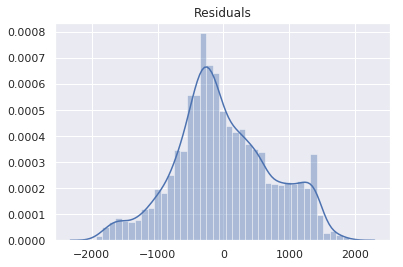

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.895
Model:                            OLS   Adj. R-squared:                  0.895
Method:                 Least Squares   F-statistic:                 2.997e+04
Date:                Sat, 27 Apr 2019   Prob (F-statistic):               0.00
Time:                        21:48:16   Log-Likelihood:                -56382.
No. Observations:                7032   AIC:                         1.128e+05
Df Residuals:                    7029   BIC:                         1.128e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -2162.4319     21.990    -98.337      0.000   -2205.539   -2119.325
x1            65.4141      0.368    177.622      0.000      64.692      66.136
x2            35.8789      0.300    119.415      0.000      35.290      36.468
==============================================================================
Omnibus:                       48.866   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               39.125
Skew:                           0.106   Prob(JB):                     3.19e-09
Kurtosis:                       2.702   Cond. No.                         198.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [8]:
numeric = sm.OLS(X_numeric.TotalCharges.values,X_numeric.drop(columns='TotalCharges').values).fit()
sns.distplot(numeric.resid)
plt.title("Residuals")
plt.show()
display(numeric.summary())

Strong regression results, remove it, check VIF again.

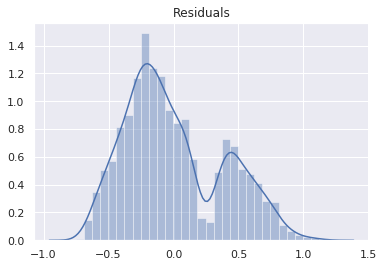

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.269
Model:                            OLS   Adj. R-squared:                  0.267
Method:                 Least Squares   F-statistic:                     172.0
Date:                Sat, 27 Apr 2019   Prob (F-statistic):               0.00
Time:                        21:48:16   Log-Likelihood:                -3132.2
No. Observations:                7032   AIC:                             6302.
Df Residuals:                    7013   BIC:                             6433.
Df Model:                          18                                         
Covariance Type:                  HC0                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3414      0.022     15.590      0.000       0.298       0.384
x1            -0.0049      0.009     -0.548      0.584      -0.023       0.013
x2             0.0513      0.015      3.497      0.000       0.023       0.080
x3             0.0009      0.011      0.082      0.935      -0.021       0.022
x4            -0.0221      0.011     -2.040      0.041      -0.043      -0.001
x5            -0.0049      0.000    -16.971      0.000      -0.005      -0.004
x6            -0.1345      0.019     -7.220      0.000      -0.171      -0.098
x7             0.0136      0.006      2.437      0.015       0.003       0.024
x8             0.0530      0.008      6.688      0.000       0.037       0.068
x9            -0.0478      0.006     -7.982      0.000      -0.060      -0.036
x10           -0.0313      0.006     -5.313      0.000      -0.043      -0.020
x11           -0.0225      0.006     -3.638      0.000      -0.035      -0.010
x12           -0.0480      0.006     -7.830      0.000      -0.060      -0.036
x13           -0.0030      0.006     -0.463      0.644      -0.016       0.010
x14           -0.0027      0.006     -0.419      0.675      -0.015       0.010
x15           -0.0376      0.007     -5.061      0.000      -0.052      -0.023
x16            0.0513      0.010      5.198      0.000       0.032       0.071
x17            0.0052      0.004      1.218      0.223      -0.003       0.013
x18            0.0040      0.000     16.594      0.000       0.004       0.005
==============================================================================
Omnibus:                      534.316   Durbin-Watson:                   2.009
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              444.548
Skew:                           0.535   Prob(JB):                     2.94e-97
Kurtosis:                       2.391   Cond. No.                         430.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC0)
"""

Variance Inflation Factors:
22.559641743616368 const
1.0016760315065845 gender
1.1494783994010138 SeniorCitizen
1.4610638584107036 Partner
1.3792261192885413 Dependents
2.7985216735122034 tenure
1.622539325070869 PhoneService
1.393720260597187 MultipleLines
1.8234327088320395 InternetService
1.2476298960500414 OnlineSecurity
1.1868414458822223 OnlineBackup
1.2799187799478504 DeviceProtection
1.3034850174394907 TechSupport
1.4437868779504393 StreamingTV
1.4436544142002523 StreamingMovies
2.480414626941157 Contract
1.202346665473795 PaperlessBilling
1.1799463280968476 PaymentMethod
2.7302856254196346 MonthlyCharges


In [9]:
X2 = X.drop(columns=['TotalCharges'])
model2 = sm.OLS(Y.values,X2.values).fit(cov_type='HC0')
sns.distplot(model2.resid)
plt.title("Residuals")
plt.show()
display(model2.summary())
print("Variance Inflation Factors:")
print_VIF(X2)

All VIFs are low now, so no more multicollinearity. Remove statistically insignificant regressors.

In [10]:
alpha = 0.05
a = model2.pvalues < alpha

In [11]:
X3 = X2[X2.columns[a]]
print("Not Statistically significant regressors are:")
print(list(X2.columns[~a]))

Not Statistically significant regressors are:
['gender', 'Partner', 'StreamingTV', 'StreamingMovies', 'PaymentMethod']


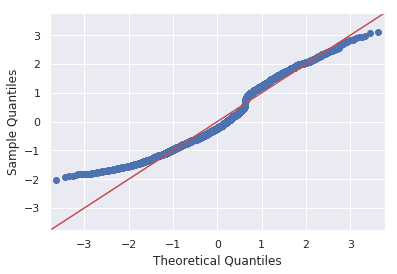

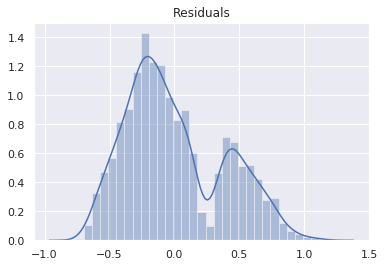

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.269
Model:                            OLS   Adj. R-squared:                  0.267
Method:                 Least Squares   F-statistic:                     237.9
Date:                Sat, 27 Apr 2019   Prob (F-statistic):               0.00
Time:                        21:48:17   Log-Likelihood:                -3133.2
No. Observations:                7032   AIC:                             6294.
Df Residuals:                    7018   BIC:                             6390.
Df Model:                          13                                         
Covariance Type:                  HC0                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3503      0.019     18.213      0.000       0.313       0.388
x1             0.0515      0.015      3.528      0.000       0.023       0.080
x2            -0.0219      0.010     -2.272      0.023      -0.041      -0.003
x3            -0.0049      0.000    -18.210      0.000      -0.005      -0.004
x4            -0.1312      0.018     -7.120      0.000      -0.167      -0.095
x5             0.0137      0.006      2.475      0.013       0.003       0.025
x6             0.0512      0.007      6.896      0.000       0.037       0.066
x7            -0.0475      0.006     -7.945      0.000      -0.059      -0.036
x8            -0.0311      0.006     -5.286      0.000      -0.043      -0.020
x9            -0.0231      0.006     -3.800      0.000      -0.035      -0.011
x10           -0.0483      0.006     -7.926      0.000      -0.060      -0.036
x11           -0.0387      0.007     -5.288      0.000      -0.053      -0.024
x12            0.0510      0.010      5.169      0.000       0.032       0.070
x13            0.0040      0.000     17.966      0.000       0.004       0.004
==============================================================================
Omnibus:                      537.126   Durbin-Watson:                   2.009
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              445.602
Skew:                           0.536   Prob(JB):                     1.73e-97
Kurtosis:                       2.389   Cond. No.                         401.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC0)
"""

Variance Inflation Factors:
16.363805268865992 const
1.1367094511454898 SeniorCitizen
1.1107927562186564 Dependents
2.54856078379417 tenure
1.5382796563958783 PhoneService
1.3878277297975659 MultipleLines
1.6030515547328335 InternetService
1.2449071755969807 OnlineSecurity
1.1861417118397548 OnlineBackup
1.2501644439699808 DeviceProtection
1.2911671941774991 TechSupport
2.4298949400451835 Contract
1.2010955728735022 PaperlessBilling
2.182045464106729 MonthlyCharges


In [12]:
model3 = sm.OLS(Y.values,X3.values).fit(cov_type='HC0')
sm.qqplot(model3.resid, sc.norm, fit=True, line='45')
plt.show()
sns.distplot(model3.resid)
plt.title('Residuals')
plt.show()
display(model3.summary())
print("Variance Inflation Factors:")
print_VIF(X3)
#sm.stats.diagnostic.breaks_hansen(model3)

In [13]:
L = list(X3.columns)
Sgn = model3.params
for i in range(14):
    print(L[i],':', np.round(Sgn[i],3))

const : 0.35
SeniorCitizen : 0.052
Dependents : -0.022
tenure : -0.005
PhoneService : -0.131
MultipleLines : 0.014
InternetService : 0.051
OnlineSecurity : -0.047
OnlineBackup : -0.031
DeviceProtection : -0.023
TechSupport : -0.048
Contract : -0.039
PaperlessBilling : 0.051
MonthlyCharges : 0.004


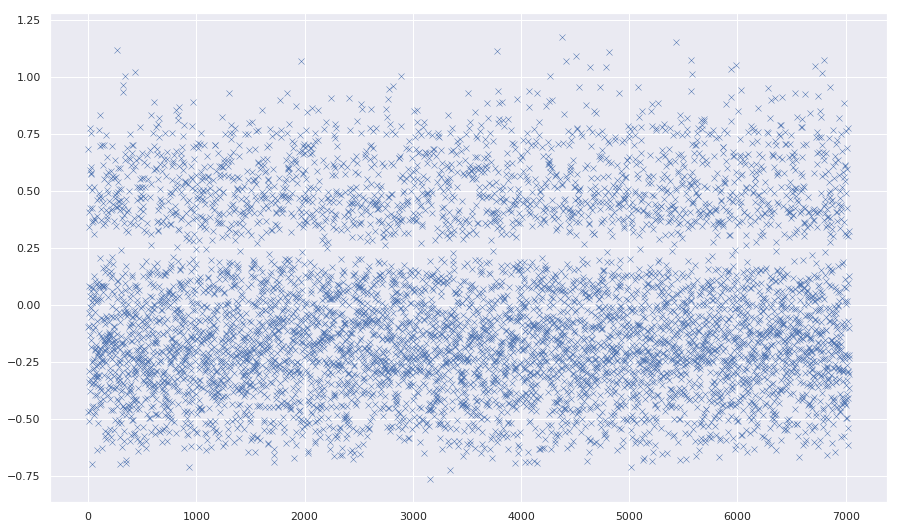

In [14]:
plt.figure(figsize=(15,9))
plt.scatter(np.ones((model3.resid.shape[0],1)).cumsum(),model3.resid, marker='x', linewidth=0.5)

In [15]:
X_train, X_test, Y_train, Y_test = train_test_split(X3.values, Y.values, test_size=0.25)

reg = LinearRegression()
reg = reg.fit(X_train,Y_train)

y_hat = reg.predict(X_test)

print('Test accuracy:',np.round(reg.score(X_test, Y_test),3), ', Cross Entropy Loss is:', log_loss(Y_test,y_hat))


Test accuracy: 0.263 , Cross Entropy Loss is: 0.5239041644625588


# Linear Classification: Logistic Regression

,const,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges
count,7032.0,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000
mean,1.0,0.504693,0.162400,0.482509,0.298493,32.421786,0.903299,0.940557,0.872582,0.789249,0.905859,0.903868,0.796359,0.984926,0.992890,0.688567,0.592719,1.573237,64.798208
std,0.0,0.500014,0.368844,0.499729,0.457629,24.545260,0.295571,0.948627,0.737271,0.859962,0.880394,0.880178,0.861674,0.885285,0.885385,0.832934,0.491363,1.067504,30.085974
min,1.0,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18.250000
25%,1.0,0.000000,0.000000,0.000000,0.000000,9.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,35.587500
50%,1.0,1.000000,0.000000,0.000000,0.000000,29.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,2.000000,70.350000
75%,1.0,1.000000,0.000000,1.000000,1.000000,55.000000,1.000000,2.000000,1.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000,1.000000,2.000000,89.862500
max,1.0,1.000000,1.000000,1.000000,1.000000,72.000000,1.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000,3.000000,118.750000


,Churn
count,7032.000000
mean,0.265785
std,0.441782
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


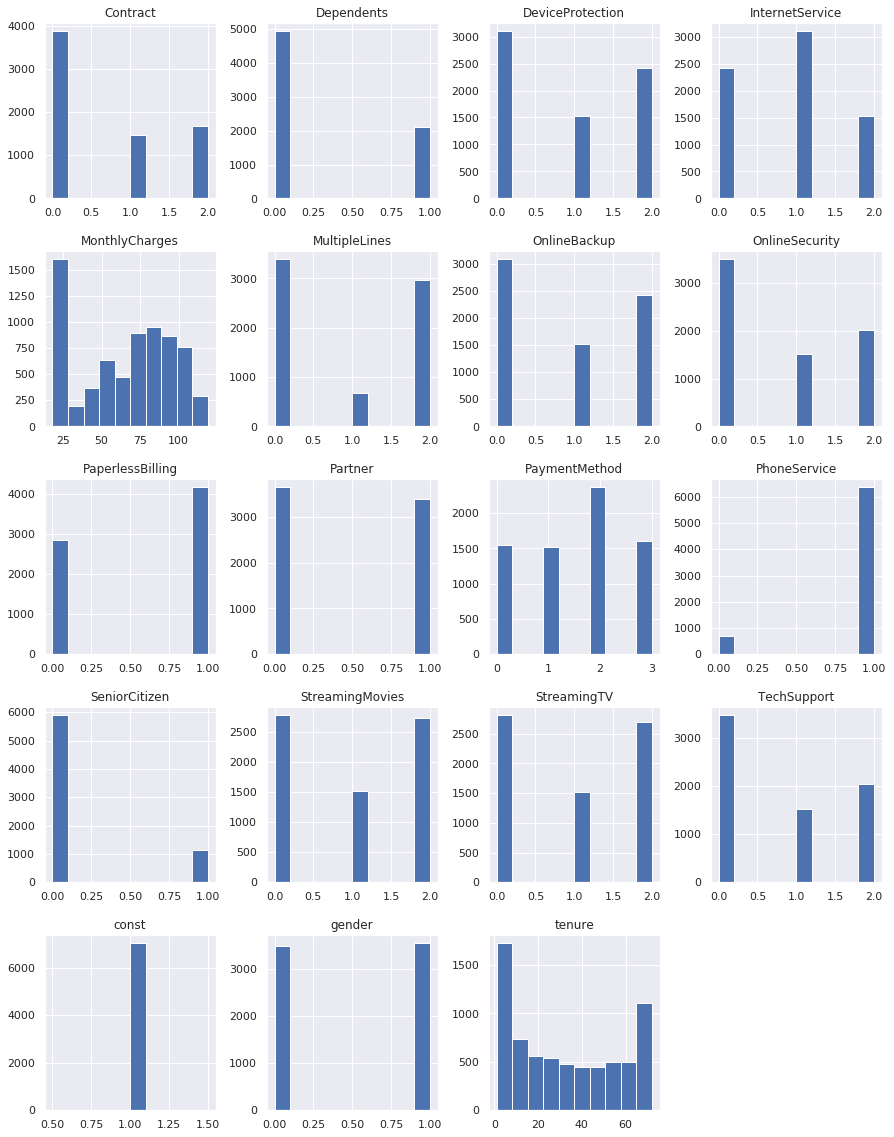

In [16]:
display(X2.describe())
display(Y.describe())
X2.hist(figsize=(15,20))
plt.show()

In [17]:
logit = sm.Logit(Y.values, X2.values).fit()
display(logit.summary())

Optimization terminated successfully.
         Current function value: 0.417703
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                 7032
Model:                          Logit   Df Residuals:                     7013
Method:                           MLE   Df Model:                           18
Date:                Sat, 27 Apr 2019   Pseudo R-squ.:                  0.2786
Time:                        21:48:19   Log-Likelihood:                -2937.3
converged:                       True   LL-Null:                       -4071.7
                                        LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.9809      0.152     -6.469      0.000      -1.278      -0.684
x1            -0.0257      0.065     -0.398      0.691      -0.152       0.101
x2             0.2395      0.085      2.833      0.005       0.074       0.405
x3             0.0149      0.077      0.193      0.847      -0.137       0.167
x4            -0.1781      0.089     -1.993      0.046      -0.353      -0.003
x5            -0.0347      0.002    -14.639      0.000      -0.039      -0.030
x6            -0.9893      0.142     -6.956      0.000      -1.268      -0.711
x7             0.0849      0.040      2.102      0.036       0.006       0.164
x8             0.2565      0.064      4.001      0.000       0.131       0.382
x9            -0.2615      0.041     -6.315      0.000      -0.343      -0.180
x10           -0.1272      0.038     -3.353      0.001      -0.202      -0.053
x11           -0.0755      0.039     -1.928      0.054      -0.152       0.001
x12           -0.2514      0.042     -5.996      0.000      -0.334      -0.169
x13            0.0074      0.041      0.181      0.856      -0.073       0.088
x14            0.0120      0.041      0.294      0.769      -0.068       0.092
x15           -0.6943      0.076     -9.085      0.000      -0.844      -0.545
x16            0.3594      0.074      4.864      0.000       0.215       0.504
x17            0.0609      0.035      1.733      0.083      -0.008       0.130
x18            0.0280      0.002     14.739      0.000       0.024       0.032
==============================================================================
"""

In [18]:
b = logit.pvalues < alpha
X4 = X2[X2.columns[b]]
print("Not Statistically significant regressors are:")
print(list(X2.columns[~b]))
print_VIF(X4)

Not Statistically significant regressors are:
['gender', 'Partner', 'DeviceProtection', 'StreamingTV', 'StreamingMovies', 'PaymentMethod']
16.277270503528957 const
1.1364359337998557 SeniorCitizen
1.1107804068212963 Dependents
2.5184485598506483 tenure
1.5213992620383683 PhoneService
1.3856851456420975 MultipleLines
1.5751534252065835 InternetService
1.243669265064246 OnlineSecurity
1.1853797864330549 OnlineBackup
1.2800017509366801 TechSupport
2.3877813515830484 Contract
1.1982953398048881 PaperlessBilling
2.1015811098758355 MonthlyCharges


In [19]:
logit2 = sm.Logit(Y.values, X4.values).fit()


#odds ratio, how a 1 unit increase in every variable affects churn chances
print(np.exp(logit2.params))
display(logit2.summary())

Optimization terminated successfully.
         Current function value: 0.418196
         Iterations 7
[0.41781275 1.27477702 0.84108974 0.96479854 0.37680105 1.09056668
 1.28478558 0.76930686 0.87932566 0.77392002 0.49106302 1.43771912
 1.02801901]


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                 7032
Model:                          Logit   Df Residuals:                     7019
Method:                           MLE   Df Model:                           12
Date:                Sat, 27 Apr 2019   Pseudo R-squ.:                  0.2778
Time:                        21:48:19   Log-Likelihood:                -2940.8
converged:                       True   LL-Null:                       -4071.7
                                        LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.8727      0.124     -7.050      0.000      -1.115      -0.630
x1             0.2428      0.084      2.895      0.004       0.078       0.407
x2            -0.1731      0.081     -2.134      0.033      -0.332      -0.014
x3            -0.0358      0.002    -15.863      0.000      -0.040      -0.031
x4            -0.9760      0.137     -7.131      0.000      -1.244      -0.708
x5             0.0867      0.040      2.156      0.031       0.008       0.166
x6             0.2506      0.061      4.112      0.000       0.131       0.370
x7            -0.2623      0.041     -6.339      0.000      -0.343      -0.181
x8            -0.1286      0.038     -3.395      0.001      -0.203      -0.054
x9            -0.2563      0.041     -6.178      0.000      -0.338      -0.175
x10           -0.7112      0.075     -9.429      0.000      -0.859      -0.563
x11            0.3631      0.074      4.926      0.000       0.219       0.508
x12            0.0276      0.002     16.239      0.000       0.024       0.031
==============================================================================
"""

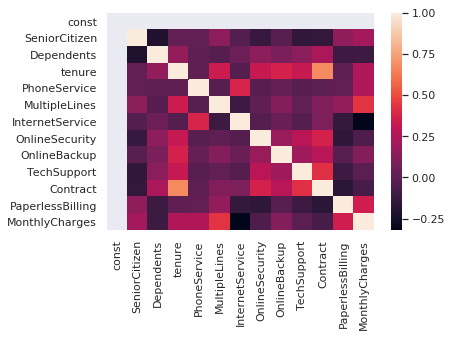

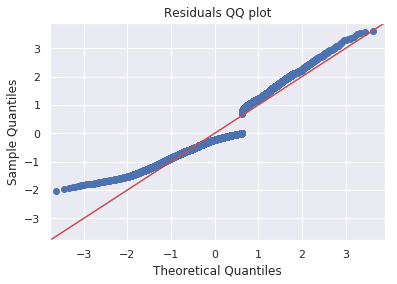

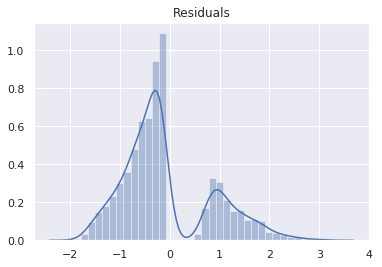

In [20]:
sns.heatmap(X4.corr(), xticklabels=X4.corr().columns,yticklabels=X4.corr().columns)
plt.show()
sm.qqplot(logit2.resid_dev, sc.norm, fit=True, line='45')
plt.title('Residuals QQ plot')
plt.show()
sns.distplot(logit2.resid_dev)
plt.title('Residuals')
plt.show()

In [21]:
L2 = list(X4.columns)
Sgn2 = logit2.params
for i in range(13):
    print(L2[i],':', np.round(np.exp(Sgn2[i]),3))

const : 0.418
SeniorCitizen : 1.275
Dependents : 0.841
tenure : 0.965
PhoneService : 0.377
MultipleLines : 1.091
InternetService : 1.285
OnlineSecurity : 0.769
OnlineBackup : 0.879
TechSupport : 0.774
Contract : 0.491
PaperlessBilling : 1.438
MonthlyCharges : 1.028


# Prediction with Logitsic Regression and Identified Variables

In [22]:
for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split(X4.values, Y.values, test_size=0.25)
    lr = LogisticRegression().fit(X_train,y_train)

    y_hat = lr.predict(X_test)
    print('Test accuracy:',np.round(lr.score(X_test, y_test),3), ', Cross Entropy Loss is:', log_loss(y_test,y_hat))


Test accuracy: 0.8 , Cross Entropy Loss is: 6.896028248389816
Test accuracy: 0.8 , Cross Entropy Loss is: 6.915677607877581
Test accuracy: 0.807 , Cross Entropy Loss is: 6.66027505022434
Test accuracy: 0.803 , Cross Entropy Loss is: 6.797798279793376
Test accuracy: 0.797 , Cross Entropy Loss is: 6.994267313657817
Test accuracy: 0.819 , Cross Entropy Loss is: 6.247694900344941
Test accuracy: 0.81 , Cross Entropy Loss is: 6.562034165622027
Test accuracy: 0.809 , Cross Entropy Loss is: 6.60132560726031
Test accuracy: 0.807 , Cross Entropy Loss is: 6.679914858206967
Test accuracy: 0.805 , Cross Entropy Loss is: 6.7192076643459835


Confusion matrix is:
[[1150  132]
 [ 210  266]]
We have 1416 correct observations and 342 misclassifications.
              precision    recall  f1-score   support

           0       0.85      0.90      0.87      1282
           1       0.67      0.56      0.61       476

   micro avg       0.81      0.81      0.81      1758
   macro avg       0.76      0.73      0.74      1758
weighted avg       0.80      0.81      0.80      1758



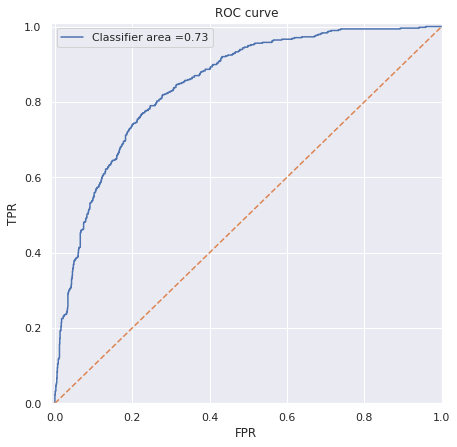

In [23]:
calculate_metrics(y_test,y_hat)
plot_ROC(y_test,X_test,lr)

# Other Models

Split the data into train and test dataset. Would need to find signficant regressors again with statsmodels, but for more complex models this isnt easy, so just use the design matrix without multicollinearity.

In [24]:
X_train, X_test, Y_train, Y_test = train_test_split(X2.values, Y.values, test_size=0.25)


## Classification - Decision tree

Test accuracy: 0.714 , Cross Entropy Loss is: 9.862725851184388
Confusion matrix is:
[[1029  258]
 [ 244  227]]
We have 1256 correct observations and 502 misclassifications.
              precision    recall  f1-score   support

           0       0.81      0.80      0.80      1287
           1       0.47      0.48      0.47       471

   micro avg       0.71      0.71      0.71      1758
   macro avg       0.64      0.64      0.64      1758
weighted avg       0.72      0.71      0.72      1758



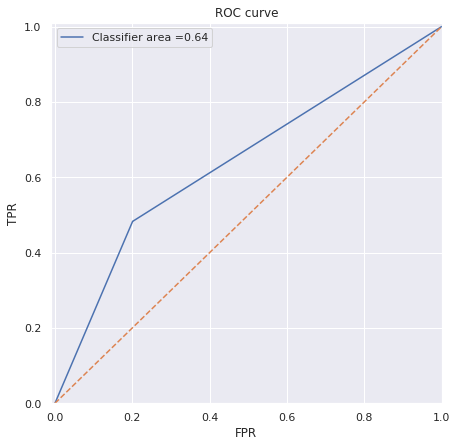

In [25]:
clf_detree = DecisionTreeClassifier()
clf_detree = clf_detree.fit(X_train,Y_train)


y_hat = clf_detree.predict(X_test)

print('Test accuracy:',np.round(clf_detree.score(X_test, Y_test),3), ', Cross Entropy Loss is:', log_loss(Y_test,y_hat))
calculate_metrics(Y_test,y_hat)
plot_ROC(Y_test,X_test,clf_detree)

## Classification - Random Forest

Test accuracy: 0.77 , Cross Entropy Loss is: 7.93730057383073
Confusion matrix is:
[[1151  136]
 [ 268  203]]
We have 1354 correct observations and 404 misclassifications.
              precision    recall  f1-score   support

           0       0.81      0.89      0.85      1287
           1       0.60      0.43      0.50       471

   micro avg       0.77      0.77      0.77      1758
   macro avg       0.70      0.66      0.68      1758
weighted avg       0.75      0.77      0.76      1758



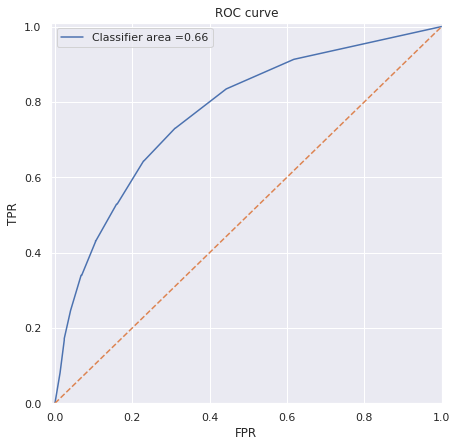

In [26]:
clf_rdfore = RandomForestClassifier()
clf_rdfore = clf_rdfore.fit(X_train,Y_train)

y_hat = clf_rdfore.predict(X_test)


print('Test accuracy:',np.round(clf_rdfore.score(X_test, Y_test),3), ', Cross Entropy Loss is:', log_loss(Y_test,y_hat))
calculate_metrics(Y_test,y_hat)
plot_ROC(Y_test,X_test,clf_rdfore)

## Classification - other

In [27]:
classifiers = [
    KNeighborsClassifier(),
    SVC(),
    GaussianProcessClassifier(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    MLPClassifier(),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]

for c,var in enumerate(classifiers):
    clf = var
    clf = clf.fit(X_train,Y_train)
    Y_pred = clf.predict(X_test)
    print(c,var,"Accuracy:",metrics.accuracy_score(Y_test, Y_pred))

0 KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform') Accuracy: 0.7571103526734926
1 SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False) Accuracy: 0.7815699658703071
2 GaussianProcessClassifier(copy_X_train=True, kernel=None,
             max_iter_predict=100, multi_class='one_vs_rest', n_jobs=None,
             n_restarts_optimizer=0, optimizer='fmin_l_bfgs_b',
             random_state=None, warm_start=False) Accuracy: 0.7366325369738339
3 DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
          